### Understanding Visual Agnosia with Computer Vision

**Neuro140 Final Project**

**Bianca Cordazzo**

### Initial Tests for improving model's performance

In [2]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [3]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Data normalization for training and validation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
# Create training and validation datasets
trainset = torchvision.datasets.CIFAR10(root = "./data/train/", train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root = "./data/test/", train=False,
                                       download=True, transform=transform)

# Create training and validation dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


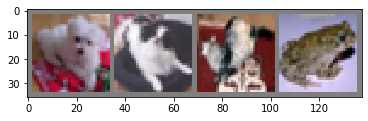

  dog   dog   cat  frog


In [6]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# titles = classes[labels[j]] for j in range(4)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Test 1:
Use ***Feature Extraction*** to Optimize Model's Performance

In [7]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
data_dir = "./data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 10

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = True

In [8]:
# References: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#             https://blog.paperspace.com/pytorch-101-building-neural-networks/
#             https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs):
    
    epoch_losses = []
    epoch_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        epoch_loss = 0.0
        losses = []
        
        # Train
        start = time.time()
        for batch_idx, data in enumerate(trainloader):
            inputs, targets = data

            optimizer.zero_grad()                 # Zero the gradients

            outputs = model(inputs)                 # Forward pass
            loss = criterion(outputs, targets)    # Compute the Loss
            loss.backward()                       # Compute the Gradients
            optimizer.step()                      # Updated the weights
            
            losses.append(loss.item())
            end = time.time()
                
        epoch_loss += outputs.shape[0] * loss.item()
        epoch_losses.append(epoch_loss/len(trainset))
        print('Train loss : %.3f' % (epoch_loss))
        
        # Evaluate
        model.eval()
        total = 0
        correct = 0

        with torch.no_grad():
            for batch_idx, data in enumerate(testloader):
                inputs, targets = data

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += predicted.eq(targets.data).cpu().sum()

            epoch_acc.append(100.*correct/total)
            print('Test Acc : %.3f' % (100.*correct/total))
            print('--------------------------------------------------------------')
        model.train() 
        
    return model, epoch_losses, epoch_acc

In [9]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(512, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# "Initialize the model for this run"
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# "Print the model we just instantiated"
# print(model_ft)

In [11]:
# References: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#             https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Setup optimizer
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss function
criterion = nn.CrossEntropyLoss()

Params to learn:
	 fc.weight
	 fc.bias


In [10]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# "Train and evaluate"
model, epoch_losses, epoch_acc = train_model(model_ft, trainloader, testloader, 
                                             criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/20
----------
Train loss : 14.486
Test Acc : 27.700
--------------------------------------------------------------
Epoch 2/20
----------
Train loss : 11.091
Test Acc : 26.480
--------------------------------------------------------------
Epoch 3/20
----------
Train loss : 8.379
Test Acc : 24.980
--------------------------------------------------------------
Epoch 4/20
----------
Train loss : 9.908
Test Acc : 27.580
--------------------------------------------------------------
Epoch 5/20
----------
Train loss : 4.128
Test Acc : 28.450
--------------------------------------------------------------
Epoch 6/20
----------
Train loss : 3.978
Test Acc : 29.300
--------------------------------------------------------------
Epoch 7/20
----------
Train loss : 12.288
Test Acc : 27.860
--------------------------------------------------------------
Epoch 8/20
----------
Train loss : 3.011
Test Acc : 26.440
--------------------------------------------------------------
Epoch 9/20
----------

<Figure size 432x288 with 0 Axes>

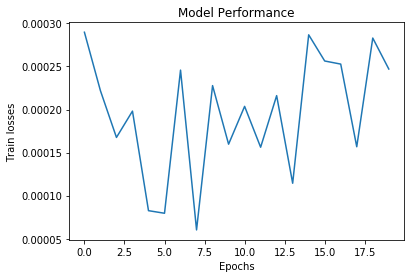

<Figure size 432x288 with 0 Axes>

In [11]:
# Plots Train losses vs. Epochs
plt.title('Model Performance')
plt.plot(epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Train losses')
plt.show()

<Figure size 432x288 with 0 Axes>

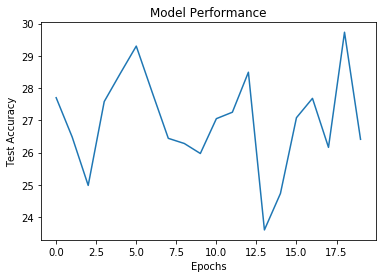

<Figure size 432x288 with 0 Axes>

In [12]:
# Plots Test Accuracy vs. Epochs
plt.title('Model Performance')
plt.plot(epoch_acc)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()

In [13]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Calculates and prints neural network's prediction
outputs = model_ft(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    car  deer  bird  bird


In [14]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Calculates the network's performance on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 25 %


In [15]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Calculates the network's performance across all classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

acc_hist = []
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    acc_hist.append(100 * class_correct[i] / class_total[i])

Accuracy of plane : 19 %
Accuracy of   car : 45 %
Accuracy of  bird : 40 %
Accuracy of   cat : 16 %
Accuracy of  deer : 21 %
Accuracy of   dog : 16 %
Accuracy of  frog : 27 %
Accuracy of horse : 15 %
Accuracy of  ship : 47 %
Accuracy of truck :  7 %


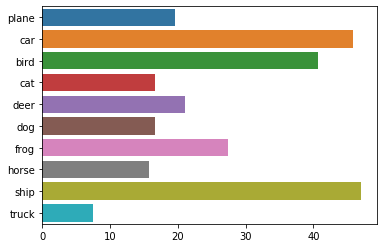

In [16]:
# barplot depicting network's performance across all classes
class_list = []
for i in classes:
    class_list.append(i)
    
ax = sns.barplot(x=acc_hist, y=class_list)

### Test 2:
Train the model ***from scratch*** to optimize performance. Also note that from here onwards we set *batch_size = 256* to speed up the training!

In [17]:
# Create training and validation dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

In [31]:
# Initialize the non-pretrained version of the model
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, 
                                   use_pretrained=False)

scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()

# Train new model
model_scratch, losses, acc = train_model(scratch_model, trainloader, testloader, 
                                         scratch_criterion, scratch_optimizer, 
                                         num_epochs=num_epochs)

Epoch 1/20
----------
Train loss : 131.508
Test Acc : 44.100
--------------------------------------------------------------
Epoch 2/20
----------
Train loss : 107.557
Test Acc : 49.900
--------------------------------------------------------------
Epoch 3/20
----------
Train loss : 89.630
Test Acc : 52.030
--------------------------------------------------------------
Epoch 4/20
----------
Train loss : 70.235
Test Acc : 54.900
--------------------------------------------------------------
Epoch 5/20
----------
Train loss : 91.395
Test Acc : 55.620
--------------------------------------------------------------
Epoch 6/20
----------
Train loss : 85.385
Test Acc : 56.700
--------------------------------------------------------------
Epoch 7/20
----------
Train loss : 60.451
Test Acc : 57.140
--------------------------------------------------------------
Epoch 8/20
----------
Train loss : 48.358
Test Acc : 57.100
--------------------------------------------------------------
Epoch 9/20
---

In [35]:
# As before, we calculate and print neural network's prediction
outputs_scratch = model_scratch(images)

_, predicted_scratch = torch.max(outputs_scratch, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted_scratch[j]]
                              for j in range(4)))

Predicted:    cat plane   dog truck


In [36]:
# Now we look at the model's overall performance
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs_scratch = model_scratch(images)
        _, predicted_scratch = torch.max(outputs_scratch.data, 1)
        total += labels.size(0)
        correct += (predicted_scratch == labels).sum().item()

print('Accuracy of the network trained from scratch on the 10000 test images: %d %%' % 
      (100 * correct / total))

Accuracy of the network trained from scratch on the 10000 test images: 57 %


In [37]:
# Now we look at the model's performance across classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs_scratch = model_scratch(images)
        _, predicted_scratch = torch.max(outputs_scratch, 1)
        c = (predicted_scratch == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


acc_hist_scratch = []
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    acc_hist_scratch.append(100 * class_correct[i] / class_total[i])

Accuracy of plane : 68 %
Accuracy of   car : 76 %
Accuracy of  bird : 84 %
Accuracy of   cat : 31 %
Accuracy of  deer : 15 %
Accuracy of   dog : 26 %
Accuracy of  frog : 33 %
Accuracy of horse : 58 %
Accuracy of  ship : 71 %
Accuracy of truck : 58 %


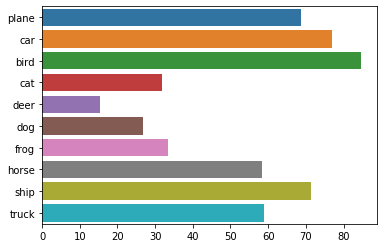

In [38]:
# Barplot to ease comparison between classes
class_list = []
for i in classes:
    class_list.append(i)
    
ax = sns.barplot(x=acc_hist_scratch, y=class_list)

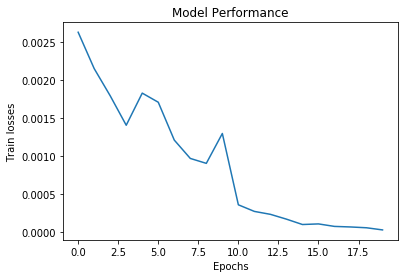

In [40]:
# Plots Train losses vs. Epochs
plt.title('Model Performance')
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Train losses')
plt.show()

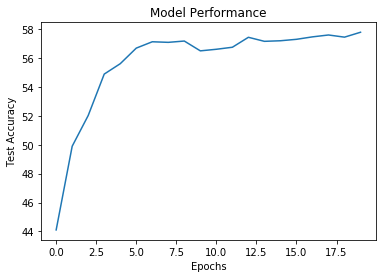

In [41]:
# Plots Test Accuracy vs. Epochs
plt.title('Model Performance')
plt.plot(acc)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()

### Other References:

- https://pytorch.org/docs/stable/torchvision/models.html
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://cs231n.github.io/transfer-learning/
- https://blog.paperspace.com/pytorch-101-building-neural-networks/
- https://discuss.pytorch.org/t/how-to-draw-loss-per-epoch/22333